In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../../')
import DLDMD as dl
import LossDLDMD as lf

%matplotlib inline

In [2]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'

tf.keras.backend.set_floatx('float64')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Running on device: {}".format(DEVICE))

TensorFlow version: 2.7.0
Eager execution: True
Num GPUs available: 0
Running on device: /CPU:0


In [3]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './harmonic_2023-03-09-1919/epoch_100_loss_-1.82'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load test data
test_data = pickle.load(open('data_test.pkl', 'rb'))
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (2000, 300, 2)


In [4]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model(test_data)
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  300


In [5]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

[y, x_ae, x_adv, y_adv, weights, evals, evecs, phi] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.0155658
Log10 Loss: -1.8078281


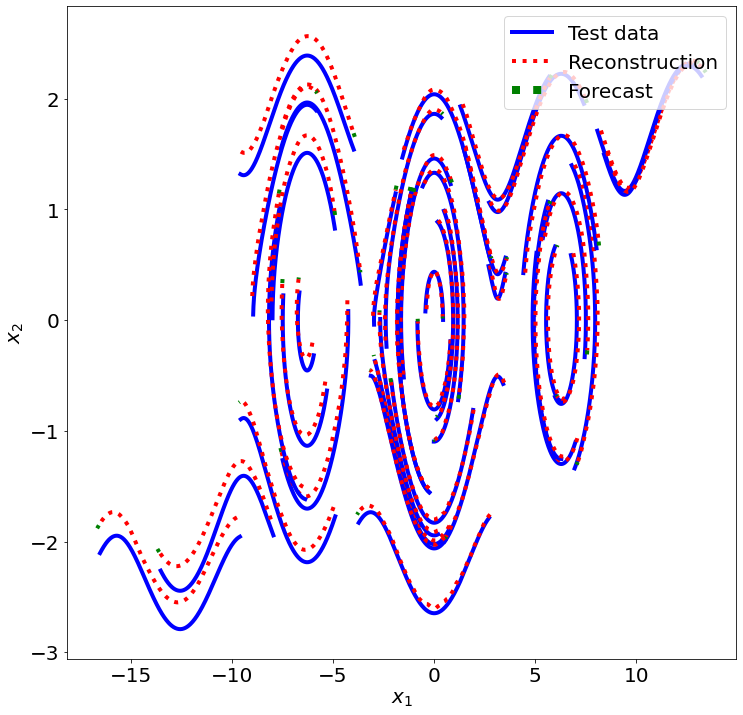

In [6]:
fs = 20
ts = 20
lw = 4
ms = 4
figsize = (12, 12)
skip = 50

# DLDMD reconstruction
fig = plt.figure(1, figsize=figsize,facecolor='white')
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'b', linestyle='solid', lw=lw)
    plt.plot(x_adv[ii, :-4, 0], x_adv[ii, :-4, 1], 'r', linestyle='dotted', lw=lw)
    plt.plot(x_adv[ii, -5:, 0], x_adv[ii, -5:, 1], 'g', linestyle='dotted', lw=lw)
plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'b', linestyle='solid', lw=lw, label='Test data')
plt.plot(x_adv[ii, :-4, 0], x_adv[ii, :-4, 1], 'r', linestyle='dotted', lw=lw,label='Reconstruction')
plt.plot(x_adv[ii, -5:, 0], x_adv[ii, -5:, 1], 'g', linestyle='dotted', lw=2*lw,label='Forecast')
plt.xlabel(r'$x_1$', fontsize=fs)
plt.ylabel(r'$x_2$', fontsize=fs)
plt.legend(fontsize=fs, loc='upper right')
#plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

fig.savefig("dldmd_test_harm_pplane", dpi=dpisave)
plt.show()

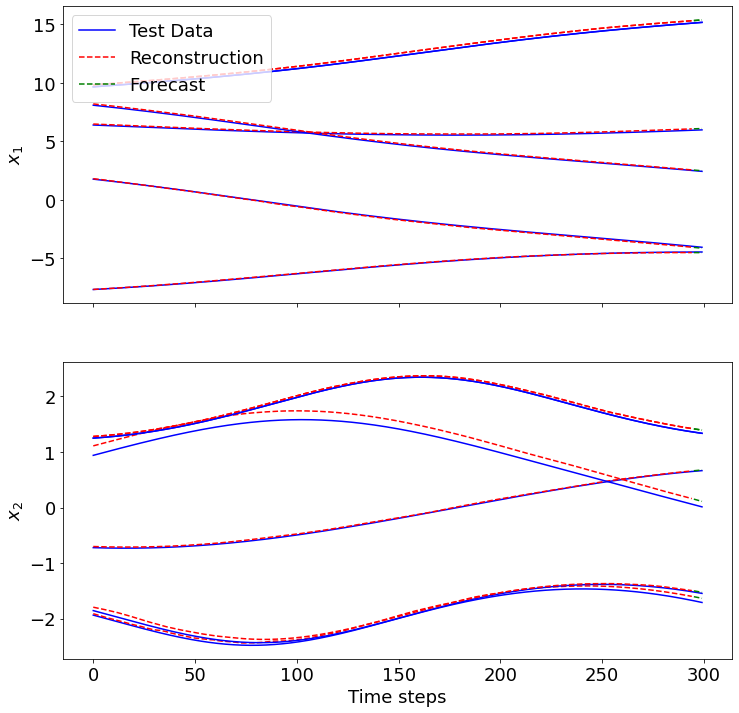

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=figsize, facecolor='white')
num_steps = range(hyp_params['num_time_steps'])
num_steps_1 =range(hyp_params['num_time_steps'] - 5)
num_steps_2 =np.arange(295,300,1)

for ii in range(5):
    axes[0].plot(num_steps,test_data[ii, :, 0],'b',linestyle='solid')
    axes[0].plot(num_steps_1,x_adv[ii,:-5,0],'r',linestyle='dashed')
    axes[0].plot(num_steps_2,x_adv[ii,-5:,0],'g',linestyle='dashed')
    axes[1].plot(num_steps,test_data[ii, :, 1],'b',linestyle='solid')
    axes[1].plot(num_steps_1,x_adv[ii,:-5,1],'r',linestyle='dashed')
    axes[1].plot(num_steps_2,x_adv[ii,-5:,1],'g',linestyle='dashed')

axes[0].plot(num_steps,test_data[ii, :, 0],'b',linestyle='solid',label = 'Test Data')
axes[0].plot(num_steps_1,x_adv[ii,:-5,0],'r',linestyle='dashed',label = 'Reconstruction')
axes[0].plot(num_steps_2,x_adv[ii,-5:,0],'g',linestyle='dashed',label = 'Forecast')
axes[1].plot(num_steps,test_data[ii, :, 1],'b',linestyle='solid',label = 'Test Data')
axes[1].plot(num_steps_1,x_adv[ii,:-5,1],'r',linestyle='dashed',label = 'Reconstruction')
axes[1].plot(num_steps_2,x_adv[ii,-5:,1],'g',linestyle='dashed',label = 'Forecast')

axes[0].set_ylabel('$x_1$')
axes[0].legend(loc = 'upper left')
axes[1].set_ylabel('$x_2$')
axes[1].set_xlabel('Time steps')

fig.savefig("dldmd_test_harm_xyz_over_num_steps", dpi=dpisave)

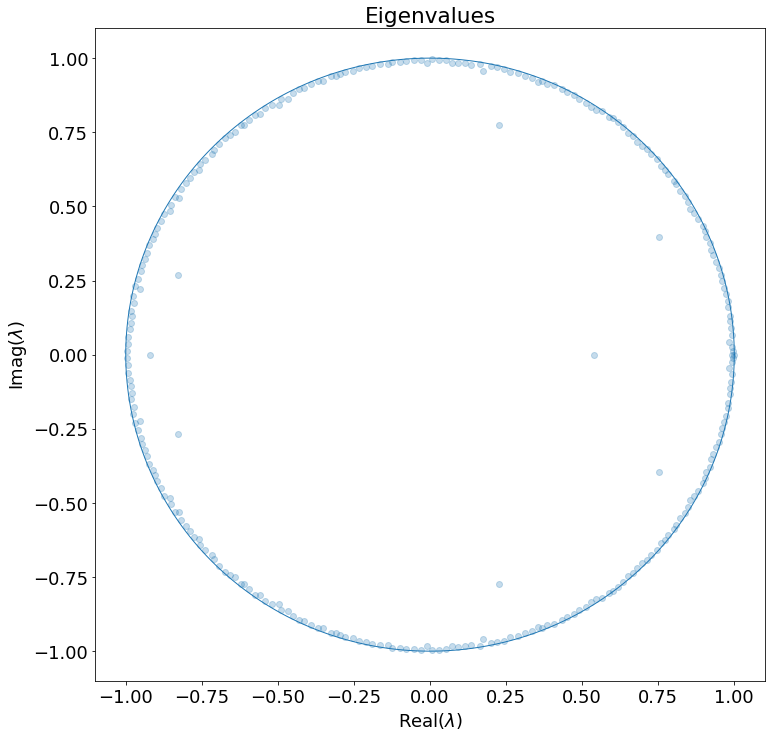

In [ ]:
#Eigenvalues
fig = plt.figure(figsize=figsize,facecolor='white')
ax = fig.add_subplot(111)
t = np.linspace(0, 2*np.pi, 300)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
ax.scatter(np.real(evals), np.imag(evals),alpha = 0.25)
ax.set_xlabel("Real$(\lambda)$")
ax.set_ylabel("Imag$(\lambda)$")
ax.set_title("Eigenvalues")
fig.savefig("dldmd_test_harm_evals", dpi=dpisave)